# Part 1: Connecting to Snowflake

In [67]:
import snowflake.connector
import os

conn = snowflake.connector.connect(
    user=os.getenv('SNOWFLAKE_USER'),
    password=os.getenv('SNOWFLAKE_PASSWORD'),
    account=os.getenv('SNOWFLAKE_ACCOUNT'),
    warehouse='COMPUTE_WH',  # Specify the warehouse
    )


In [68]:
cs = conn.cursor()

## Creating Warehouse

In [82]:
cs.execute("CREATE WAREHOUSE IF NOT EXISTS my_first_warehouse")

## Creating Database

In [83]:
cs.execute("CREATE DATABASE IF NOT EXISTS testdb")

## Creating Schema

In [86]:
cs.execute("CREATE SCHEMA IF NOT EXISTS testschema")

## Cleaning Monthly PO Data

Below, we are adjusting the date and time columns in the myriad of monthly PO csv's to a Date/Time format which can be uploaded into a table within Snowflake. Once the data format is cleaned, we are creating new CSV's with the cleaned data.

In [ ]:
import pandas as pd
import os

# Directory containing your CSV files (same location as your script)
csv_directory = '.'  # Refers to the current directory

# Loop through each file in the directory
for filename in os.listdir(csv_directory):
    if filename.endswith('.csv'):
        # Load the CSV file
        file_path = os.path.join(csv_directory, filename)
        df = pd.read_csv(file_path)
        
        # Standardize the date format for 'OrderDate', 'ExpectedDeliveryDate', 'LastReceiptDate'
        df['OrderDate'] = pd.to_datetime(df['OrderDate'], errors='coerce').dt.strftime('%m/%d/%Y')
        df['ExpectedDeliveryDate'] = pd.to_datetime(df['ExpectedDeliveryDate'], errors='coerce').dt.strftime('%m/%d/%Y')
        df['LastReceiptDate'] = pd.to_datetime(df['LastReceiptDate'], errors='coerce').dt.strftime('%m/%d/%Y')

        # Standardize the timestamp format for 'LastEditedWhen' and 'Right_LastEditedWhen'
        df['LastEditedWhen'] = pd.to_datetime(df['LastEditedWhen'], errors='coerce').dt.strftime('%m/%d/%Y %I:%M %p')
        df['Right_LastEditedWhen'] = pd.to_datetime(df['Right_LastEditedWhen'], errors='coerce').dt.strftime('%m/%d/%Y %I:%M %p')
        
        # Save the cleaned CSV back to the same location
        cleaned_file_path = os.path.join(csv_directory, 'cleaned_' + filename)
        df.to_csv(cleaned_file_path, index=False)
        print(f"Processed {filename}")


## Creating new stage

In [12]:
cs.execute("""
    CREATE OR REPLACE STAGE my_stage
    FILE_FORMAT = (TYPE = 'CSV')
""")

## Putting cleaned data into Snowflake

In [45]:
import os

# Directory where the cleaned CSV files are located
csv_directory = '.'  # Current directory

# Loop through and upload only files that start with 'cleaned_'
for filename in os.listdir(csv_directory):
    if filename.startswith('cleaned_cleaned_') and filename.endswith('.csv'):
        # Build the full file path
        full_file_path = os.path.join(csv_directory, filename)

        # Prepare the PUT command for each file
        upload_query = f"""
            PUT file://{full_file_path} @my_stage;
        """

        # Execute the query to upload the file
        cs.execute(upload_query)
        print(f"File {filename} uploaded successfully.")


File cleaned_cleaned_2019-8.csv uploaded successfully.
File cleaned_cleaned_2019-10.csv uploaded successfully.
File cleaned_cleaned_2021-6.csv uploaded successfully.
File cleaned_cleaned_2020-6.csv uploaded successfully.
File cleaned_cleaned_2021-10.csv uploaded successfully.
File cleaned_cleaned_2020-5.csv uploaded successfully.
File cleaned_cleaned_2019-5.csv uploaded successfully.
File cleaned_cleaned_2021-4.csv uploaded successfully.
File cleaned_cleaned_2021-9.csv uploaded successfully.
File cleaned_cleaned_2019-1.csv uploaded successfully.
File cleaned_cleaned_2019-6.csv uploaded successfully.
File cleaned_cleaned_2021-5.csv uploaded successfully.
File cleaned_cleaned_2020-8.csv uploaded successfully.
File cleaned_cleaned_2020-4.csv uploaded successfully.
File cleaned_cleaned_2021-3.csv uploaded successfully.
File cleaned_cleaned_2022-4.csv uploaded successfully.
File cleaned_cleaned_2022-3.csv uploaded successfully.
File cleaned_cleaned_2019-2.csv uploaded successfully.
File cle

## Creating PO Table in Snowflake with proper data types

In [64]:
create_POtable_query = """
    CREATE OR REPLACE TABLE purchase_orders (
        PurchaseOrderID INT,
        SupplierID INT,
        OrderDate DATE,
        DeliveryMethodID INT,
        ContactPersonID INT,
        ExpectedDeliveryDate DATE,
        SupplierReference STRING,
        IsOrderFinalized BOOLEAN,
        Comments STRING,
        InternalComments STRING,
        LastEditedBy INT,
        LastEditedWhen TIMESTAMP,
        PurchaseOrderLineID INT,
        StockItemID INT,
        OrderedOuters INT,
        Description STRING,
        ReceivedOuters INT,
        PackageTypeID INT,
        ExpectedUnitPricePerOuter FLOAT,
        LastReceiptDate DATE,
        IsOrderLineFinalized BOOLEAN,
        Right_LastEditedBy INT,
        Right_LastEditedWhen TIMESTAMP
    );
"""
cs.execute(create_POtable_query)
print("Table created successfully.")

Table created successfully.


In [13]:
# Command to remove all files from the Snowflake stage
remove_stage_query = "REMOVE @my_stage;"

# Execute the REMOVE command to clear the stage
cs.execute(remove_stage_query)
print("All files removed from the stage.")


All files removed from the stage.


## Loading data into PO Table with proper data types specified

In [65]:
load_data_query = """
    COPY INTO purchase_orders
    FROM @my_stage
    FILE_FORMAT = (
        TYPE = 'CSV',
        SKIP_HEADER = 1,
        DATE_FORMAT = 'MM/DD/YYYY',
        TIME_FORMAT = 'HH12:MI AM',
        TIMESTAMP_FORMAT = 'MM/DD/YYYY HH12:MI AM',
        FIELD_OPTIONALLY_ENCLOSED_BY = '"',  -- To handle commas and newlines inside quoted fields
        ESCAPE_UNENCLOSED_FIELD = None       -- To handle special characters
    );
"""
cs.execute(load_data_query)
print("Data loaded into table successfully.")

Data loaded into table successfully.


## Verifying data has been loaded correctly

In [52]:
cs.execute("SELECT * FROM purchase_orders LIMIT 10")

rows = cs.fetchall()

# Get the column names from the cursor description
columns = [desc[0] for desc in cs.description]

# Create a pandas DataFrame
df = pd.DataFrame(rows, columns=columns)

# Display the DataFrame (this automatically displays as a table in Jupyter or some IDEs)
print(df)

   PURCHASEORDERID  SUPPLIERID   ORDERDATE  DELIVERYMETHODID  CONTACTPERSONID  \
0                1           2  2019-01-01                 9                2   
1                1           2  2019-01-01                 9                2   
2                1           2  2019-01-01                 9                2   
3               10          10  2019-01-02                 8                2   
4               11          12  2019-01-02                 7                2   
5               11          12  2019-01-02                 7                2   
6               11          12  2019-01-02                 7                2   
7               12           4  2019-01-03                 7                2   
8               12           4  2019-01-03                 7                2   
9               12           4  2019-01-03                 7                2   

  EXPECTEDDELIVERYDATE SUPPLIERREFERENCE  ISORDERFINALIZED COMMENTS  \
0           2019-01-15          B2084

## Dropping unused columns

In [66]:
cs.execute("ALTER TABLE purchase_orders DROP COLUMN Comments, InternalComments")


## Creating PO Amount field in table

Created a calculated field that shows purchase order totals, i.e., for each order, sum the line-item amounts (defined as ReceivedOuters * ExpectedUnitPricePerOuter), and name this field POAmount

In [ ]:
cs.execute("ALTER TABLE purchase_orders ADD COLUMN POAmount FLOAT")

In [75]:
cs.execute("UPDATE purchase_orders SET POAmount = (ReceivedOuters * ExpectedUnitPricePerOuter)")

# Load the supplier invoice XML data

In [136]:
cs.execute("PUT file://../Supplier_Transactions_XML.xml @my_stage AUTO_COMPRESS=TRUE;")

In [151]:
cs.execute("CREATE OR REPLACE TABLE supplier_transactions_raw (src VARIANT);")


In [152]:
a = """COPY INTO supplier_transactions_raw
FROM @my_stage
FILE_FORMAT = (TYPE = XML);
"""

cs.execute(a)

In [153]:
b = """SELECT src
FROM supplier_transactions_raw
LIMIT 5;
"""

cs.execute(b)

rows = cs.fetchall()

# Get the column names from the cursor description
columns = [desc[0] for desc in cs.description]

# Create a pandas DataFrame
df = pd.DataFrame(rows, columns=columns)

# Display the DataFrame (this automatically displays as a table in Jupyter or some IDEs)
print(df)

                                                 SRC
0  <root>\n  <row>\n    <SupplierTransactionID>13...


In [157]:
c = """
WITH xml_data AS (
    SELECT raw_xml:root AS root_content
    FROM supplier_transactions_raw
)
SELECT
    XMLGET(f.value, 'SupplierID')::NUMBER AS SupplierID
FROM xml_data,
LATERAL FLATTEN(input => root_content.row) f;

"""

cs.execute(c)

rows = cs.fetchall()

# Get the column names from the cursor description
columns = [desc[0] for desc in cs.description]

# Create a pandas DataFrame
df = pd.DataFrame(rows, columns=columns)

# Display the DataFrame (this automatically displays as a table in Jupyter or some IDEs)
print(df)


ProgrammingError: 001003 (42000): SQL compilation error:
syntax error line 8 at position 38 unexpected 'row'.
syntax error line 8 at position 37 unexpected '.'.

We were not able to parse the XML file using the COPY INTO command. We tried the multiple methods to parse or read the data, and received errors each time. We are now parsing the data within Python. 

## Parsing XML data within Python

In [3]:
import xml.etree.ElementTree as ET
import pandas as pd

# Step 1: Parse the XML file
tree = ET.parse('../Supplier_Transactions_XML.xml')  # Replace with your actual XML file path
root = tree.getroot()

# Step 2: Create an empty list to store the extracted data
data = []

# Step 3: Loop through each row in the XML and extract the data
for row in root.findall('row'):
    SupplierTransactionID = row.find('SupplierTransactionID').text
    SupplierID = row.find('SupplierID').text
    TransactionTypeID = row.find('TransactionTypeID').text
    PurchaseOrderID = row.find('PurchaseOrderID').text
    PaymentMethodID = row.find('PaymentMethodID').text
    SupplierInvoiceNumber = row.find('SupplierInvoiceNumber').text
    TransactionDate = row.find('TransactionDate').text
    AmountExcludingTax = row.find('AmountExcludingTax').text
    TaxAmount = row.find('TaxAmount').text
    TransactionAmount = row.find('TransactionAmount').text
    OutstandingBalance = row.find('OutstandingBalance').text
    FinalizationDate = row.find('FinalizationDate').text
    IsFinalized = row.find('IsFinalized').text
    LastEditedBy = row.find('LastEditedBy').text
    LastEditedWhen = row.find('LastEditedWhen').text

    # Append the extracted data to the list
    data.append({
        'SupplierTransactionID': SupplierTransactionID,
        'SupplierID': SupplierID,
        'TransactionTypeID': TransactionTypeID,
        'PurchaseOrderID': PurchaseOrderID,
        'PaymentMethodID': PaymentMethodID,
        'SupplierInvoiceNumber': SupplierInvoiceNumber,
        'TransactionDate': TransactionDate,
        'AmountExcludingTax': AmountExcludingTax,
        'TaxAmount': TaxAmount,
        'TransactionAmount': TransactionAmount,
        'OutstandingBalance': OutstandingBalance,
        'FinalizationDate': FinalizationDate,
        'IsFinalized': IsFinalized,
        'LastEditedBy': LastEditedBy,
        'LastEditedWhen': LastEditedWhen
    })

# Step 4: Convert the list of dictionaries to a pandas DataFrame
df = pd.DataFrame(data)

# Step 5: Display the DataFrame
print(df)




     SupplierTransactionID SupplierID TransactionTypeID PurchaseOrderID  \
0                      134          2                 5               1   
1                      169          4                 5               2   
2                      186          5                 5               3   
3                      215          7                 5               4   
4                      224         10                 5               5   
...                    ...        ...               ...             ...   
2433                335510          4                 5            2070   
2434                335511          4                 7            None   
2435                335512          7                 7            None   
2436                335843          4                 5            2071   
2437                335847          7                 5            2072   

     PaymentMethodID SupplierInvoiceNumber TransactionDate AmountExcludingTax  \
0                 

## Creating Supplier Transaction CSV after parsing XML data

In [6]:
df.to_csv('supplier_transactions.csv', index=False)

## Staging cleaned Supplier Transaction data into Snowflake

In [14]:
cs.execute("PUT file://supplier_transactions.csv @my_stage AUTO_COMPRESS=TRUE;")

## Creating Supplier Transaction Table in Snowflake with proper data types

In [15]:
create_query = """CREATE OR REPLACE TABLE supplier_transactions (
    SupplierTransactionID INT,
    SupplierID INT,
    TransactionTypeID INT,
    PurchaseOrderID FLOAT,
    PaymentMethodID INT,
    SupplierInvoiceNumber FLOAT,
    TransactionDate DATE,
    AmountExcludingTax FLOAT,
    TaxAmount FLOAT,
    TransactionAmount FLOAT,
    OutstandingBalance FLOAT,
    FinalizationDate DATE,
    IsFinalized BOOLEAN,
    LastEditedBy INT,
    LastEditedWhen TIMESTAMP
);
"""

cs.execute(create_query)

## Loading data into Supplier Transaction Table with proper data types specified

In [17]:
load_data_query = """
    COPY INTO supplier_transactions
    FROM @my_stage
    FILE_FORMAT = (
    TYPE = 'CSV',
    SKIP_HEADER = 1,
    DATE_FORMAT = 'YYYY-MM-DD',  -- Adjusted to match the date format in your CSV
    TIME_FORMAT = 'HH12:MI AM',
    TIMESTAMP_FORMAT = 'YYYY-MM-DD HH12:MI:SS.FF',  -- Adjusted timestamp format
    FIELD_OPTIONALLY_ENCLOSED_BY = '"',  -- To handle commas and newlines inside quoted fields
    ESCAPE_UNENCLOSED_FIELD = None       -- To handle special characters
);
"""
cs.execute(load_data_query)

## Creating New table for purchases showing PO Amount grouped by PurchaseOrderID

We need to group the PO Amount by PurchaseOrderID to show the total amount spent on each purchase order. There are multiple purchases per purchase order.

In [23]:
create_table = """CREATE OR REPLACE TABLE purchases_grouped AS
    SELECT PurchaseOrderID, SupplierID, SUM(POAmount) AS POAmount
    FROM purchase_orders
    GROUP BY PurchaseOrderID, SupplierID
;
"""

cs.execute(create_table)

## Creating New table Combining Invoice and Purchase data

In [104]:
create_table = """CREATE OR REPLACE TABLE purchases_invoices AS
    SELECT A.PurchaseOrderID, A.SupplierID, A.POAmount, B.AmountExcludingTax, B.TaxAmount, B.TransactionAmount, B.TransactionDate
    FROM purchases_grouped A
    JOIN supplier_transactions B
    ON A.PurchaseOrderID = B.PurchaseOrderID
;
"""

cs.execute(create_table)

## Creating View which shows the difference between the invoiced and quoted amounts

In [106]:
create_view = """CREATE OR REPLACE VIEW purchases_orders_and_invoices AS
    SELECT *, (AmountExcludingTax - POAmount) AS "Invoiced vs. Quoted"
    FROM purchases_invoices
;
"""

cs.execute(create_view)

# Loading Supplier Case Data

## Connecting to PostGres Database

In [1]:
import psycopg2

# Step 1: Connect to PostgreSQL
conn = psycopg2.connect(
    host="127.0.0.1",
    port="8765",
    database="WestCoastImporters", 
    user="jovyan", 
    password="postgres"
)

# Step 2: Create a cursor object
cur = conn.cursor()


## Exporting Supplier Case Data to Local Machine

Prior to this, we put the supplier case data into WestCoastImporters database in PostGres. We are now exporting the data to our local machine. See photo below showing supplier_case table in PostGres.

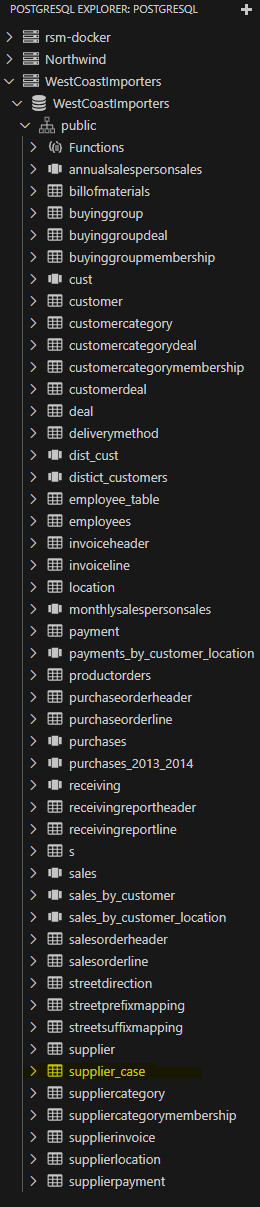

In [2]:
local_file_path = 'supplier_case_data.csv'

copy_sql = """
COPY supplier_case TO STDOUT WITH CSV HEADER DELIMITER ',';
"""

# Step 4: Open a file and execute the copy command, writing the output to a file
with open(local_file_path, 'w') as f_output:
    cur.copy_expert(copy_sql, f_output)

# Close the cursor and connection
cur.close()
conn.close()

print(f"Data exported to {local_file_path}")

Data exported to supplier_case_data.csv


In [14]:
# Command to remove all files from the Snowflake stage
remove_stage_query = "REMOVE @my_stage;"

# Execute the REMOVE command to clear the stage
cs.execute(remove_stage_query)
print("All files removed from the stage.")


All files removed from the stage.


## Staging Supplier Case Data into Snowflake

In [7]:
cs.execute("PUT file://supplier_case_data.csv @my_stage AUTO_COMPRESS=TRUE;")

## Creating Supplier Case Table in Snowflake with proper data types

In [8]:
create_query = """CREATE OR REPLACE TABLE supplier_case (
    supplierid INT,
    suppliername STRING,
    suppliercategoryid INT,
    primarycontactpersonid INT,
    alternatecontactpersonid INT,
    deliverymethodid FLOAT,
    postalcityid INT,
    supplierreference STRING,
    bankaccountname STRING,
    bankaccountbranch STRING,
    bankaccountcode INT,
    bankaccountnumber INT,
    bankinternationalcode INT,
    paymentdays INT,
    internalcomments STRING,
    phonenumber STRING,
    faxnumber STRING,
    websiteurl STRING,
    deliveryaddressline1 STRING,
    deliveryaddressline2 STRING,
    deliverypostalcode INT,
    deliverylocation STRING,
    postaladdressline1 STRING,
    postaladdressline2 STRING,
    postalpostalcode INT,
    lasteditedby INT,
    validfrom TIME,  -- This might need to be adjusted to DATE if it's actual date-time data
    validto STRING     -- Adjust to appropriate format if needed
);
"""

cs.execute(create_query)

## Loading data into Supplier Case Table with proper data types specified

In [10]:
load_data_query = """
    COPY INTO supplier_case
    FROM @my_stage
    FILE_FORMAT = (
    TYPE = 'CSV',
    SKIP_HEADER = 1,
    DATE_FORMAT = 'YYYY-MM-DD',  -- Adjusted to match the date format in your CSV
    TIME_FORMAT = 'HH:MI.SS.FF',
    TIMESTAMP_FORMAT = 'YYYY-MM-DD HH12:MI:SS.FF',  -- Adjusted timestamp format
    FIELD_OPTIONALLY_ENCLOSED_BY = '"',  -- To handle commas and newlines inside quoted fields
    ESCAPE_UNENCLOSED_FIELD = None       -- To handle special characters
);
"""
cs.execute(load_data_query)

TXT File

# Loading Geo Location TXT File into Snowflake

## Staging Geo Location Data into Snowflake

In [15]:
cs.execute("PUT file://../2021_Gaz_zcta_national.txt @my_stage AUTO_COMPRESS=TRUE;")

## Creating Geo Location Table in Snowflake with proper data types

In [16]:
create_query = """CREATE OR REPLACE TABLE geo_table (
    GEOID STRING,             -- Assuming the GEOID is treated as a string (can contain leading zeros)
    ALAND BIGINT,             -- ALAND is a large integer representing area in square meters
    AWATER BIGINT,            -- AWATER is a large integer representing water area in square meters
    ALAND_SQMI FLOAT,         -- ALAND_SQMI is a floating-point number representing area in square miles
    AWATER_SQMI FLOAT,        -- AWATER_SQMI is a floating-point number representing water area in square miles
    INTPTLAT FLOAT,           -- INTPTLAT is a floating-point number for the latitude
    INTPTLONG FLOAT           -- INTPTLONG is a floating-point number for the longitude
);

"""

cs.execute(create_query)

## Loading data into Geo Location Table with proper data types specified

In [18]:
load_data_query = """
    COPY INTO geo_table
    FROM @my_stage
    FILE_FORMAT = (
        TYPE = 'CSV',
        SKIP_HEADER = 1,
        FIELD_DELIMITER = '\t',  -- Assuming the file is tab-delimited
        FIELD_OPTIONALLY_ENCLOSED_BY = '"',
        DATE_FORMAT = 'YYYY-MM-DD',  -- Adjust to match any date columns (if present)
        TIME_FORMAT = 'HH:MI.SS.FF',  -- Adjust to match time columns (if present)
        TIMESTAMP_FORMAT = 'YYYY-MM-DD HH12:MI:SS.FF'  -- Adjust timestamp format if applicable
    );
"""
cs.execute(load_data_query)


## Creating View which combines Weather Station Location Data and Temperature Data

We are only interested in maximum temp for each day, and the date ranges for our invoice and purchase data which are between the years of 2019 and 2022, so we are filtering for this data. 

In [97]:
cs.execute("USE DATABASE TESTDB;")
cs.execute("USE SCHEMA TESTSCHEMA;")
create_weather_view_w_temp = """CREATE OR REPLACE VIEW weather_stations_with_temp AS (
    SELECT DISTINCT w.*, t.NOAA_WEATHER_STATION_ID AS ts_weather_station_id, t.Date, t.Value AS "Maximum Daily Temp (C)"
    FROM WEATHER__ENVIRONMENT.CYBERSYN.NOAA_WEATHER_STATION_INDEX w
    JOIN WEATHER__ENVIRONMENT.CYBERSYN.NOAA_WEATHER_METRICS_TIMESERIES t
    ON w.NOAA_WEATHER_STATION_ID = t.NOAA_WEATHER_STATION_ID
    WHERE t.Variable = 'maximum_temperature'
    AND t.Date BETWEEN '2019-01-01' AND '2022-12-31'
);"""

cs.execute(create_weather_view_w_temp)

## Creating View which calculates closest weather station to each Geo Point through Lat/Long

Since we are assuming we don't know the zip code of the Weather stations, we are calculating the closest weather station to each Geo Point through the latitude and longitude of the Geo Point using the ST_DISTANCE function. We created a variable called rn which is the row number partitioned by the Geo Point ID and ordered by the distance between the Geo Point and the Weather Station. We then filter the view to only show the closest weather station to each Geo Point (rn = 1).

In [98]:
create_weather_station_view = """
CREATE OR REPLACE VIEW weather_stations AS (
WITH geo_points AS (
    SELECT *, ST_MakePoint(intptlong, intptlat) AS geo_loc
    FROM testdb.testschema.geo_table
),
weather_points AS (
    SELECT *, ST_MakePoint(longitude, latitude) AS station_loc
    FROM weather_stations_with_temp
),
distances AS (
    SELECT 
        s.*,
        w.*,
        ST_Distance(s.geo_loc, w.station_loc) AS distance,
        ROW_NUMBER() OVER (PARTITION BY w.ZIP_NAME ORDER BY ST_Distance(s.geo_loc, w.station_loc)) AS rn
    FROM geo_points s
    CROSS JOIN weather_points w
    WHERE ABS(s.intptlong - w.longitude) < 1 
    AND ABS(s.intptlat - w.latitude) < 1
)
SELECT *
FROM distances
WHERE rn = 1
);"""

cs.execute(create_weather_station_view)

## Create View Matching Zip Codes from Weather Stations to Zip Codes from our Supplier Locations

In [102]:
create_supplier_zip_code_weather_view = """
CREATE OR REPLACE VIEW supplier_zip_code_weather AS (
    SELECT DISTINCT A.postalpostalcode, w.Date, w."Maximum Daily Temp (C)"
    FROM testdb.testschema.supplier_case A
    JOIN weather_stations w
    ON A.postalpostalcode = w.ZIP_NAME
    GROUP BY A.postalpostalcode, w.Date, w."Maximum Daily Temp (C)"
    ORDER BY A.postalpostalcode, w.Date
);
"""

cs.execute(create_supplier_zip_code_weather_view)

## Re-combining supplier_case and supplier_zip_code_weather

Based on guidance from the project information, we are to only include zip code, date, and max daily temp for our supplier_zip_code_weather view. We could include supplierid in that view as well since that is what is needed to combine the supplier_zip_code_weather view with the purchase/invoice data, but we were intsructed to only include zip code, date, and max daily temp. So, we are re-combining the supplier_case and supplier_zip_code_weather view and supplier case based on zip code.

In [103]:
combine_supplier_case_weather_view = """
CREATE OR REPLACE VIEW supplier_case_weather AS (
SELECT B.*, A.Date, A."Maximum Daily Temp (C)"
FROM testdb.testschema.supplier_zip_code_weather A
LEFT JOIN testdb.testschema.supplier_case B
ON A.postalpostalcode = B.postalpostalcode
);
"""

cs.execute(combine_supplier_case_weather_view)

# Combining Supplier/Weather Data and Purchase/Invoice Data for Final Table

We created a table which combines the supplier/zip code/weather data and the purchase/invoice data on both supplierID and the transaction date.

The table is large and takes a long time to bring up, so we are just viewing the first 10 rows of the table.

In [122]:
supplier_weather_data_and_purchases_invoices = """
CREATE OR REPLACE VIEW supplier_weather_data_and_purchases_invoices AS (
SELECT b.PurchaseOrderID, b.SupplierID, b.POAmount, b.AmountExcludingTax, b.TaxAmount, b.TransactionAmount, b.TransactionDate, a.Date, a."Maximum Daily Temp (C)"
FROM testdb.testschema.supplier_case_weather a
JOIN testdb.testschema.purchases_orders_and_invoices b
ON a.SupplierID = b.SupplierID AND a.Date = b.TransactionDate
WHERE "Maximum Daily Temp (C)" IS NOT NULL
ORDER BY a.Date, b.PurchaseOrderID
);
"""

In [123]:
cs.execute(supplier_weather_data_and_purchases_invoices)

In [124]:
cs.execute("SELECT * FROM supplier_weather_data_and_purchases_invoices LIMIT 10")

rows = cs.fetchall()

# Get the column names from the cursor description

columns = [desc[0] for desc in cs.description]

# Create a pandas DataFrame

df = pd.DataFrame(rows, columns=columns)

# Display the DataFrame (this automatically displays as a table in Jupyter or some IDEs)

df.head()